# Recommendation system - Coke or Pepsi?

The aim of this project is to use collaborative filtering to 

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from surprise import evaluate, Reader, Dataset
from surprise import KNNBasic, SVD, BaselineOnly, CoClustering, SlopeOne
import seaborn as sns

In [2]:
full_data = pd.read_csv("two_weeks_purchases_data_for_similarities.csv")#"full_data_for_similarities.csv")
print(full_data.head(3))
full_data.shape[0]

   Unnamed: 0  cust_id    prod_id  total_spent
0           0    29568  999151604         1.99
1           1    29568  999153604         9.00
2           2    29568  999153856         3.54


472063

In [3]:
user_items = full_data#.sample(n=5000, random_state=1)

In [4]:
pepsis = [ '999167784', '999225580', '999237426', '999349816', '999590416']
cokes =  [ '999153856', '999153857', '999165545', '999266066', '999279093', '999335824',
           '999422862', '999165976', '999248329', '999261787', '999329593', '999186855',
           '999341136', '999449211', '999329592', '999224991', '999279092', '999279094',
           '999289563', '999642204', '999298467', '999245271']

user_items['Brand'] = 'N'
user_items.loc[user_items.prod_id.isin(pepsis), 'Brand'] = 'P'
user_items.loc[user_items.prod_id.isin(cokes), 'Brand'] = 'C'

cust_column = 'cust_id'
product_column = 'prod_id'
value_column = 'total_spent'

In [5]:
coke_list = []
pepsi_list = []
def find_estimated_sales(predictions):
    est_pepsi_sale = 0
    est_coke_sale = 0
    for uid, iid, true_r, est, _ in predictions:
        if str(iid) in pepsis: # Yes coke.
            pepsi_list.append([uid, iid, est])        
        elif str(iid) in cokes:
            coke_list.append([uid, iid, est])

In [6]:
reader = Reader(rating_scale=(user_items[value_column].min(), user_items[value_column].max()))
data = Dataset.load_from_df(user_items[[cust_column, product_column, value_column]], reader)
trainingSet = data.build_full_trainset()
#tesSet = trainingSet.build_anti_testset()

In [7]:
merged = cokes.append(pepsis)
df_to_predict = user_items.loc[user_items.Brand.isin(['P', 'C']), :].reset_index()
test_coke_pep = Dataset.load_from_df(df_to_predict[[cust_column, product_column, value_column]], reader)
testSet = test_coke_pep.build_full_trainset().build_anti_testset()

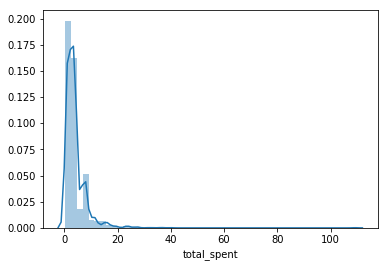

In [8]:
sns.distplot(df_to_predict[value_column])

In [9]:
print('Using SlopeOne')
sim_options = {
                'name': 'pearson',
                'user_based': True #by looking at similarity in purchase patterns of users
              }
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
              }

algo = SlopeOne()
algo.fit(trainingSet)

Using SlopeOne


In [10]:
pred_SlopeOne = algo.test(testSet)

In [11]:
find_estimated_sales(pred_SlopeOne)
coke_df = pd.DataFrame(coke_list, columns=[cust_column, product_column, 'est_will_spend'])
pepsi_df = pd.DataFrame(pepsi_list, columns=[cust_column, product_column, 'est_will_spend'])
coke_df.to_csv("coke_estimationsSlopeOne_full.csv")
pepsi_df.to_csv("pepsi_estimationsSlopeOne_full.csv")

del coke_list[:]
del pepsi_list[:]

In [12]:
print('Using KNNBasic')
sim_options = {
    'name': 'pearson',
    'user_based': True
   # 'min_support' : 4
}

knn = KNNBasic(sim_options=sim_options)
knn.fit(trainingSet)

Using KNNBasic
Computing the pearson similarity matrix...
Done computing similarity matrix.


C:\Python27\lib\site-packages\surprise\prediction_algorithms\algo_base.py:293: RuntimeWarning: invalid value encountered in sqrt
  sim = construction_func[name](*args)


In [13]:
pred_KNNBasic = knn.test(testSet)

In [14]:
find_estimated_sales(pred_KNNBasic)
coke_df = pd.DataFrame(coke_list, columns=[cust_column, product_column, 'est_will_spend'])
pepsi_df = pd.DataFrame(pepsi_list, columns=[cust_column, product_column, 'est_will_spend'])
coke_df.to_csv("coke_estimationsKNNBasic_full.csv")
pepsi_df.to_csv("pepsi_estimationsKNNBasic_full.csv")

del coke_list[:]
del pepsi_list[:]

In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {  'name': ['pearson'],
                'user_based': [True],
               # 'min_support': range(1, 10, 2),
                 'k' : range(150, 200, 10)}
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
algo = gs.best_estimator['rmse']
algo.fit(trainingSet)

In [ ]:
pred_GridCV = algo.test(testSet)

In [ ]:
find_estimated_sales(pred_KNNBasic)
coke_df = pd.DataFrame(coke_list, columns=[cust_column, product_column, 'est_will_spend'])
pepsi_df = pd.DataFrame(pepsi_list, columns=[cust_column, product_column, 'est_will_spend'])
coke_df.to_csv("coke_estimationsGridCV_full_2.csv")
pepsi_df.to_csv("pepsi_estimationGridCV_full_2.csv")

del coke_list[:]
del pepsi_list[:]

In [ ]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.to_csv("cross_validation_results_2.csv")